In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import train_test_split
from pandas.tseries.offsets import BDay
from sklearn.metrics import mean_squared_error

# Additional Factor: EPIDEMIC - COVID-19 EFFECTS.

In [21]:
# Load the datasets
stock_data = pd.read_csv('./appl.csv')
covid_data = pd.read_csv('./na_covid_data_merged.csv', index_col=0)

# Convert the 'Date' columns to datetime format in both datasets
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
covid_data['Date'] = pd.to_datetime(covid_data['Date'])

# Merge stock data and COVID-19 data by date
merged_data = pd.merge(stock_data, covid_data, on='Date', how='inner')

# Filter the merged data for dates between 2020-01-22 and 2023-03-09
# merged_data_filtered = merged_data[(merged_data['Date'] >= '2020-01-22') & (merged_data['Date'] <= '2023-03-09')]

In [17]:
covid_data

,Date,total,new
0,2020-01-22,1,0
1,2020-01-23,3,2
2,2020-01-24,5,2
3,2020-01-25,5,0
4,2020-01-26,8,3
...,...,...,...
1138,2023-03-05,108256726,-3569
1139,2023-03-06,108266967,10241
1140,2023-03-07,108303129,36162
1141,2023-03-08,108368825,65696


In [22]:
merged_data

,Date,Open,Close,Highest,Lowest,total,new
0,2020-01-22,79.6450,79.4250,79.9975,79.3275,1,0
1,2020-01-23,79.4800,79.8075,79.8900,78.9125,3,2
2,2020-01-24,80.0625,79.5775,80.8325,79.3797,5,2
3,2020-01-27,77.5150,77.2375,77.9425,76.2200,8,0
4,2020-01-28,78.1500,79.4225,79.6000,78.0475,9,1
...,...,...,...,...,...,...,...
784,2023-03-03,148.0450,151.0300,151.1100,147.3300,108257732,59519
785,2023-03-06,153.7850,153.8300,156.3000,153.4600,108266967,10241
786,2023-03-07,153.7000,151.6000,154.0299,151.1300,108303129,36162
787,2023-03-08,152.8100,152.8700,153.4700,151.8300,108368825,65696


In [29]:

merged_data['DateNum'] = (merged_data['Date'] - merged_data['Date'].min()).dt.days  # Numerical date feature


# Prepare features and target variable
X = merged_data[['DateNum', 'Open', 'Highest', 'Lowest', 'total', 'new']].copy()
y = merged_data['Close'].copy()

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a kernel with hyperparameters
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))

# Instantiate and fit the Gaussian Process model
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp.fit(X_train, y_train)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=10),
                         n_restarts_optimizer=10)

In [30]:
# Make predictions on the test set
y_pred, sigma = gp.predict(X_test, return_std=True)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 17853.20809677702


In [34]:
# Predictions for the next 7 days
last_known_date = merged_data['Date'].max()
date_range_next_7_days = [last_known_date + pd.Timedelta(days=i) for i in range(1, 8)]
days_since_start_next_7_days = [(date - merged_data['Date'].min()).days for date in date_range_next_7_days]

last_known_values = merged_data.iloc[-1][['Open', 'Highest', 'Lowest', 'total', 'new']]
X_next_7_days = pd.DataFrame({
    'DateNum': days_since_start_next_7_days,
    'Open': last_known_values['Open'],
    'Highest': last_known_values['Highest'],
    'Lowest': last_known_values['Lowest'],
    'total': last_known_values['total'],
    'new': last_known_values['new'],
})

In [35]:
y_pred_next_7_days, sigma_next_7_days = gp.predict(X_next_7_days, return_std=True)

# Display predictions
for date, prediction, uncertainty in zip(date_range_next_7_days, y_pred_next_7_days, sigma_next_7_days):
    print(f"Date: {date.date()}, Predicted Close: {prediction:.2f}, Uncertainty: ±{uncertainty:.2f}")

Date: 2023-03-10, Predicted Close: 150.46, Uncertainty: ±1.33
Date: 2023-03-11, Predicted Close: 150.06, Uncertainty: ±2.65
Date: 2023-03-12, Predicted Close: 149.40, Uncertainty: ±3.97
Date: 2023-03-13, Predicted Close: 148.48, Uncertainty: ±5.27
Date: 2023-03-14, Predicted Close: 147.31, Uncertainty: ±6.57
Date: 2023-03-15, Predicted Close: 145.89, Uncertainty: ±7.84
Date: 2023-03-16, Predicted Close: 144.22, Uncertainty: ±9.10


In [36]:
stock_data[(stock_data['Date'] >= '2023-03-10') & (stock_data['Date'] <= '2023-03-16')]

,Date,Open,Close,Highest,Lowest
2268,2023-03-10,150.210,148.50,150.940,147.6096
2269,2023-03-13,147.805,150.47,153.140,147.7000
2270,2023-03-14,151.280,152.59,153.400,150.1000
2271,2023-03-15,151.190,152.99,153.245,149.9200
2272,2023-03-16,152.160,155.85,156.460,151.6400


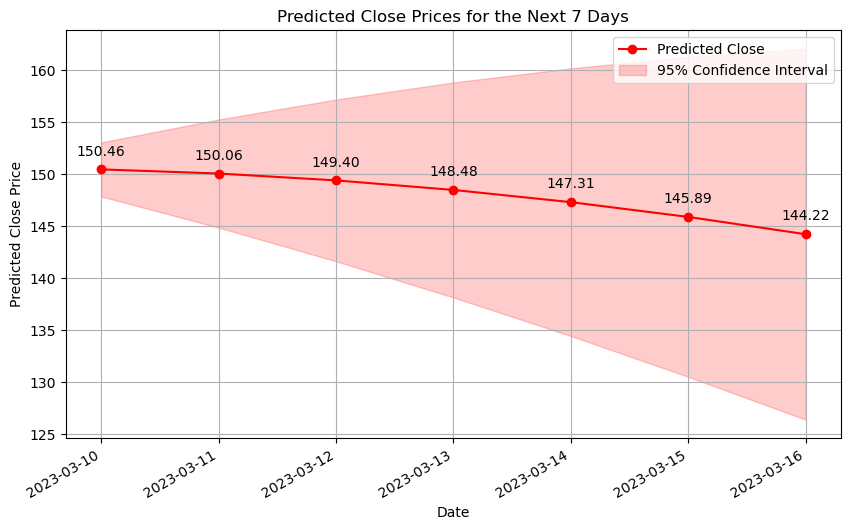

In [38]:
# Ensure date_range_next_7_days is a list of pandas datetime objects for plotting
date_range_next_7_days = pd.to_datetime(date_range_next_7_days)

plt.figure(figsize=(10, 6))

# Plotting the predicted Close prices for the next 7 days
plt.plot(date_range_next_7_days, y_pred_next_7_days, 'ro-', label='Predicted Close')

# Calculating and plotting the 95% confidence interval
lower_bound = y_pred_next_7_days - 1.96 * sigma_next_7_days
upper_bound = y_pred_next_7_days + 1.96 * sigma_next_7_days
plt.fill_between(date_range_next_7_days, lower_bound, upper_bound, color='red', alpha=0.2, label='95% Confidence Interval')

# Annotating each prediction with its value
for i, txt in enumerate(y_pred_next_7_days):
    plt.annotate(f"{txt:.2f}", (mdates.date2num(date_range_next_7_days[i]), y_pred_next_7_days[i]), textcoords="offset points", xytext=(0,10), ha='center')

# Formatting the plot
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gcf().autofmt_xdate() # Rotate date labels for better readability
plt.xlabel('Date')
plt.ylabel('Predicted Close Price')
plt.title('Predicted Close Prices for the Next 7 Days')
plt.legend()
plt.grid(True)
plt.show()

# SPECIAL TOPICS: GAMESTOP STOCKS, 2021 Spike.